### BZAN 6357 Frameworks and Methods
# Final Project

# Table of Contents (need to re-edit it)
- [Introduction](#Introduction)
- [Project Objective](#Project_Objective)
- [Data Preparation](#Data_preparation)
- [Exploratory Data Analysis](#EDA)
- [Model Development and Evaluation](#Model_development)
- [Summary](#Summary)

<a id='Introduction'></a>
# Introduction

<a id='Project_Objective'></a>
# Project Objective

<a id='Data_preparation'></a>
## <font color='blue'>1.- Data Preparation </font>

<a id='symbols'></a>
## Import packages

In [93]:
import numpy as np
import pandas as pd
from numpy import NaN as NA
import numpy.random as random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('ticks')


In [2]:
np.random.seed(30)
random_state = 30

## Open Source packages

In [87]:
import tensorflow as tf
# print(tf.__version__)

In [88]:
from tensorflow import keras
# print(keras.__version__)

In [4]:
# this is so that results are replicable
# DO NOT CHANGE THIS!!
tf.random.set_seed(random_state)

## Useful functions

In [3]:
# function for Sigmoid activation
def Sigmoid(z):
    z_clip = np.clip(z, -250, 250)
    sigmoid = 1. / (1. + np.exp(-z_clip))
    return sigmoid

## Read data

In [56]:
insur_t = pd.read_csv('bzan6357_insurance_3_TRAINING.csv')
insur_s =pd.read_csv('bzan6357_insurance_3_SCORE.csv')

### *verify there is no missing value in both sets*

In [32]:
print('there is {} missing value(s) in the train set'.format(insur_t.isna().sum().sum()))
print('~' * 50)
print('there is {} missing value(s) in the test set'.format(insur_s.isna().sum().sum()))

there is 0 missing value(s) in the train set
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
there is 0 missing value(s) in the test set


In [33]:
insur_t.dtypes

id_new              object
buy                  int64
age                  int64
gender              object
tenure               int64
region               int64
dl                   int64
has_v_insurance      int64
v_age               object
v_accident          object
v_prem_quote       float64
cs_rep               int64
dtype: object

# Preprocess data

In [57]:
X = insur_t.drop(columns=['id_new','buy'])
y = insur_t['buy']


In [67]:
# Performing the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state, shuffle=True)

### *Evaluate validity of split using hypothesis-testing*

#### equal proportion for cases y=1

In [68]:
count_default_train = y_train.value_counts()[1]
count_default_test = y_test.value_counts()[1]
z_stat, p = proportions_ztest(count=[count_default_train, count_default_test], nobs=[y_train.shape[0], y_test.shape[0]])
print('z-stat = {:0.3f}, p = {:0.3f}'.format(z_stat, p))

z-stat = 0.369, p = 0.712


**Analysis**:

p-value > 0.5 , the Null Hypothesis is accepted.

### *Column transformer: streamline data preprocessing on train and test sets*

#### ont-hot-encoder

In [69]:
X_train.head(8)

,age,gender,tenure,region,dl,has_v_insurance,v_age,v_accident,v_prem_quote,cs_rep
10452,70,male,116,28,1,0,> 2 years,yes,26550.0,122
15752,32,male,47,35,1,1,< 1 year,yes,24835.0,151
3482,38,male,279,46,1,0,1-2 year,yes,20056.0,154
16062,21,male,274,8,1,1,< 1 year,no,2630.0,163
15363,23,female,46,39,1,1,< 1 year,no,30924.0,151
4337,66,male,261,28,1,0,1-2 year,yes,53591.0,122
5526,24,male,21,47,1,0,< 1 year,yes,2630.0,151
19685,21,female,257,50,1,1,< 1 year,yes,36989.0,163


In [76]:
onehot_encoder = OneHotEncoder(drop='first')

# prepare list of column labels for one-hot-encoder
cols_onehot = ['gender', 'v_age', 'v_accident']

#### min-max-norm

In [77]:
mmn_scaler = MinMaxScaler()

# prepare list of column labels for mmn-norm: those columns in X_train that are not in cols_onehot
cols_mmn_scale = X_train.drop(columns=cols_onehot).columns.tolist()

#### column transformer

In [78]:
transformer = make_column_transformer((onehot_encoder, cols_onehot), (mmn_scaler, cols_mmn_scale))

# use fit_transform() to fit train set X vars
X_train_processed = transformer.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed)

# once fitted to train set, only use transform() on the test set X vars
X_test_processed = transformer.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed)

In [79]:
X_train_processed

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,1.0,1.0,0.769231,0.366782,0.538462,1.0,0.0,0.050957,0.000000
1,1.0,1.0,0.0,1.0,0.184615,0.128028,0.673077,1.0,1.0,0.047304,0.707317
2,1.0,0.0,0.0,1.0,0.276923,0.930796,0.884615,1.0,0.0,0.037123,0.780488
3,1.0,1.0,0.0,0.0,0.015385,0.913495,0.153846,1.0,1.0,0.000000,1.000000
4,0.0,1.0,0.0,0.0,0.046154,0.124567,0.750000,1.0,1.0,0.060275,0.707317
...,...,...,...,...,...,...,...,...,...,...,...
12271,0.0,0.0,0.0,1.0,0.630769,0.768166,0.538462,1.0,0.0,0.069704,0.780488
12272,1.0,0.0,1.0,1.0,0.323077,0.633218,0.192308,1.0,0.0,0.073209,1.000000
12273,1.0,0.0,0.0,1.0,0.846154,0.415225,0.538462,1.0,0.0,0.095240,0.000000
12274,0.0,0.0,0.0,0.0,0.123077,0.429066,0.134615,1.0,0.0,0.084910,0.780488


<a id='EDA'></a>
## <font color = 'blue'>2.- EDA</font>

In [92]:
insur_t.dtypes

id_new              object
buy                  int64
age                  int64
gender              object
tenure               int64
region               int64
dl                   int64
has_v_insurance      int64
v_age               object
v_accident          object
v_prem_quote       float64
cs_rep               int64
dtype: object

<AxesSubplot:>

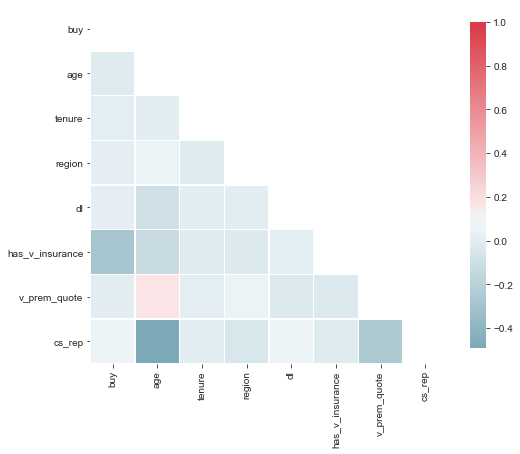

In [90]:
# get the correlation matrix for visualization and for a closer look later
corr = insur_t.drop(labels=['gender', 'v_age', 'v_accident', 'id_new'], axis=1).corr()

# prepare tools for making a half-matrix correlation heatmap
mask = np.triu(np.ones_like(corr, bool))
f, ax = plt.subplots(1,1, figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.1, square=True, ax=ax, 
            linewidths=.5, cbar_kws={'shrink': .75})

# <font color = 'red'> Draw boxplot for Nominal variables </font>

<a id='Model_development'></a>
## <font color = 'blue'>3.- Model Development and Evaluation</font>

# <font color = 'red'> Use Keras library</font>

# <font color = 'red'> Use Cross Validation</font>

<a id='Summary'></a>
## <font color = 'blue'>4.- Summary</font>